# 1 - Simple Experiment Analysis with Regression

### This example walks us through using a simple regression model to do an experiment analysis


Let's repurpose a data set from a marketing-oriented Kaggle competition to simulate data from a traditional A/B Test on our company's landing page



With this data set, we can examine a scenario where a random subset of users receive a new "treatment," which in our example will be a new updated landing page with product information and a clear Call to Action, and the remaining users receive our companies tired legacy landing page. 



For this example's simplicity, our test's target metric is a generic "conversion" rate from the page which could represent a click, a sale, a mailing list subscription, or any other conversion metric one could assign on the page



Note: this is an extreme example, not all A/B tests will be so productive!



In [1]:
import pandas as pd
import statsmodels.formula.api as smf

In [2]:
df = pd.read_parquet('data/simple_experiment_criteo_as_timeseries.parquet')
df.head()

,treatment,conversion,date,experiment_cohort
1248450,1,1,2024-07-01,new_website
8171836,1,0,2024-07-01,new_website
13669646,1,0,2024-07-01,new_website
9706402,1,0,2024-07-01,new_website
9189682,1,0,2024-07-01,new_website


In [3]:
df.describe()

,treatment,conversion,date
count,656929.000000,656929.000000,656929
mean,0.878061,0.062068,2024-08-16 00:14:09.757584128
min,0.000000,0.000000,2024-07-01 00:00:00
25%,1.000000,0.000000,2024-07-24 00:00:00
50%,1.000000,0.000000,2024-08-16 00:00:00
75%,1.000000,0.000000,2024-09-08 00:00:00
max,1.000000,1.000000,2024-10-01 00:00:00
std,0.327215,0.241278,NaN


The data set has 657k rows, with an  overall average conversion rate of 6.2% . Let's compare the site performance

In [4]:
agg = df.groupby('experiment_cohort').conversion.agg(['sum', 'count']).reset_index()
agg.columns = ['index', 'conversions', 'site_visits']
agg['conversion_rate'] = agg['conversions'] / agg['site_visits']
agg

,index,conversions,site_visits,conversion_rate
0,control_old_website,4063,80105,0.050721
1,new_website,36711,576824,0.063643


From this we see that the new website drove an absolute lift of 1.29% over the old website's conversion rate


You could use a calculator like Evan Miller's site to see if this is statisticaly significant:



![screenshot from Evan Miller Chi-Sqaure test calculator](img/evan_miller_chi_sq_example.png "Title")

We see the new website converts at a higher rate with statistical significance.

**but why talk about a basic A/B test if we're supposed to be learning about time series?**


Traditional Chi-Square and T-Tests don't have a concept of time, even though actual experiments we run are unfolding over time. 

Seeing A/B test legs play out as "competing" time series can start to give us intuition on how to measure pseudo-experiments, where it's not always possible to produce a true control

Let's plot this experiment over time!

<Axes: title={'center': 'Simulated Landing Page Experiment\nExperiment Exposures (Traffic) over Time'}, xlabel='date'>

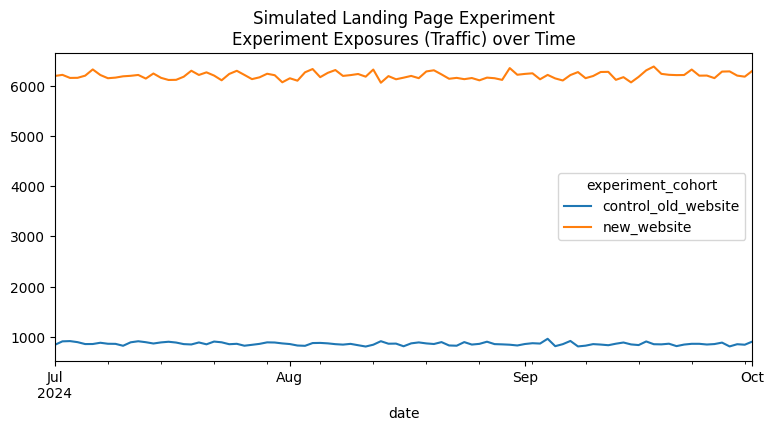

In [5]:
df.groupby(['date', 'experiment_cohort']).conversion.count().unstack()\
.plot(
    title='Simulated Landing Page Experiment\nExperiment Exposures (Traffic) over Time',
    kind='line',
    figsize=(9,4)
)

<Axes: title={'center': 'Simulated Landing Page Experiment\nDaily Conversion Rate'}, xlabel='date'>

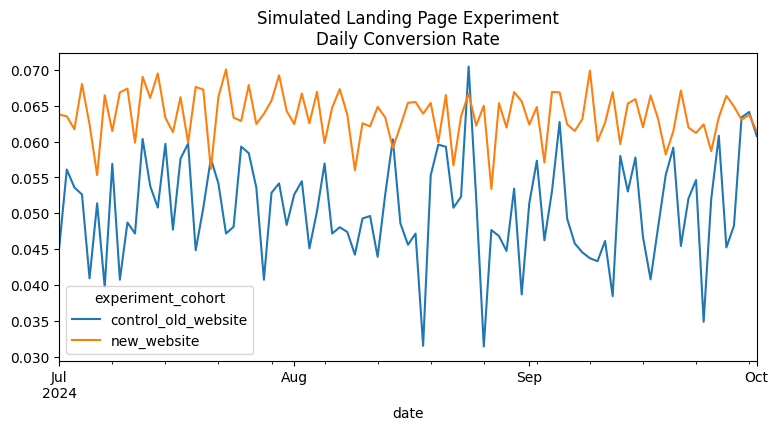

In [6]:
df.groupby(['date', 'experiment_cohort']).conversion.sum().unstack().div(
  df.groupby(['date', 'experiment_cohort']).conversion.count().unstack()
).plot(
    title='Simulated Landing Page Experiment\nDaily Conversion Rate',
    kind='line',
    figsize=(9,4)
)

From the daily data in these charts, we can see that the new website is generally performing better, but remember that a Chi-Squared Test or T-Test are statisticts on all available up until the point of computation. A better visualization of this data is to show the cumulative conversion rates of each test leg over time.

The convergence of the difference between the trends **is the effect size of the new treatment**.

<Axes: title={'center': 'Simulated Landing Page Experiment\nCumulative Conversion Rate over Time'}, xlabel='date'>

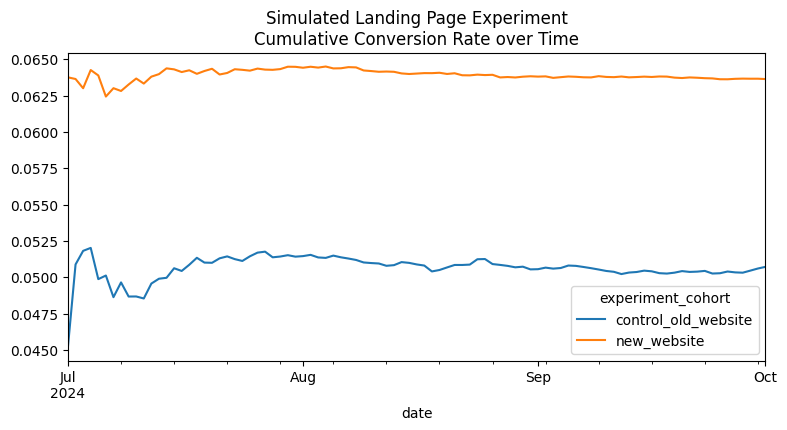

In [7]:
df.groupby(['date', 'experiment_cohort']).conversion.sum().unstack().cumsum().div(\
df.groupby(['date', 'experiment_cohort']).conversion.count().unstack().cumsum())\
.plot(
    title='Simulated Landing Page Experiment\nCumulative Conversion Rate over Time',
    figsize=(9,4)
)

### Fun Math Fact: Most simple statistical tests are just linear models in disguise

I talk about this a lot, but here's an actual example!

Let's analyze this same experiment using a simple linear regression! I'll use an R-Style formula that would translate directly into R's `lm` function

In [8]:
lm = smf.ols(formula='conversion ~ treatment', data=df)
result = lm.fit()


In [9]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     201.8
Date:                Tue, 15 Oct 2024   Prob (F-statistic):           8.50e-46
Time:                        20:56:21   Log-Likelihood:                 1983.5
No. Observations:              656929   AIC:                            -3963.
Df Residuals:                  656927   BIC:                            -3940.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0507      0.001     59.507      0.0

#### Based on this, we see a statistically significant lift of 1.29% (absolute) to Conversion Rate from the New Website

### So why bother doing it this way if it's just the same result?

 - Fast to code- the whole statistical analysis is done by just passing the line `y ~ x` into a function
 - You can stratify against other categorical variables, and this actually helps increase power! (CUPED)
 - Expand your model to consider multiple treatments or conditions and their interactions
 - Gives you measures of how well the model fits your data (R^2, AIC/BIC)




### This isn't just a pitch to use regression for every A/B test.... even though it is....


Let's plot the original data set again, but as a time series that shows cumulative trial rates over time


<Axes: title={'center': 'Simulated Landing Page Experiment\nCumulative Conversion Rate over Time'}, xlabel='date'>

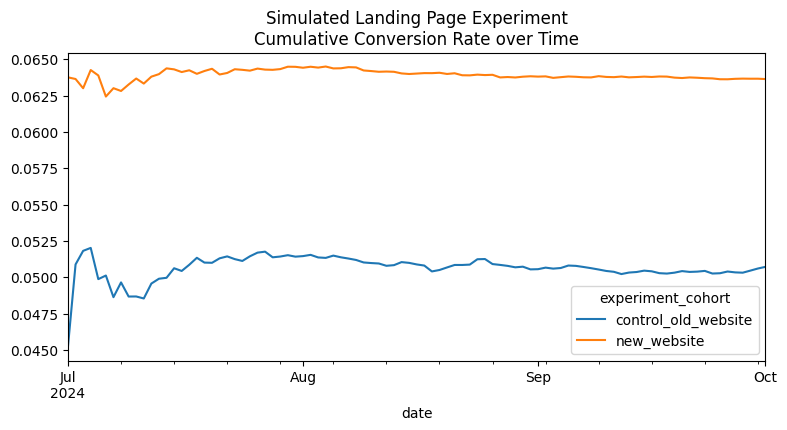

In [10]:
df.groupby(['date', 'experiment_cohort']).conversion.sum().unstack().cumsum().div(\
df.groupby(['date', 'experiment_cohort']).conversion.count().unstack().cumsum())\
.plot(
    title='Simulated Landing Page Experiment\nCumulative Conversion Rate over Time',
    figsize=(9,4)
)


**key lesson:** the distance between the control and variant lines is the effect size. since this is a cumulative plot, the gap that these lines converge to is the average aggregate effect or LATE (local average treatment effect)



**Here's some light theory of why this works!**

It's really all just `y = mx + b`, which is the equation for drawing a line. Our slope changes a bit because of the treatment. 

![alt text](img/miami_simple_regression_1.png "Title")

![alt text](img/miami_simple_regression_2.png "Title")

[citation for the slides](https://www.fsb.miamioh.edu/lij14/500_slide_sr.pdf) - thanks U Miami of Ohio!